# **SpaceX Falcon9 launch prediction project** 
### **<span style="color:#ff9933">Part 4: Machine Learning</span>** 
**Mason Phung**   
Last edited: December 2024

*Space Exploration Technologies Corp. or SpaceX is an American spacecraft manufacturer, popular for their successful mission in sending a spacecraft and astronauts to the International Space Station. They are also well-known for their [VTVL](https://en.wikipedia.org/wiki/VTVL) rocket launches , in which rockets can land and be resued, thus save a huge amount of launching cost for the company.*

*One of SpaceX's most popular rocket - the Falcon 9, have landed and reflown [more than 200 times](https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches) . The rocket was advertised on its website with a launch cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch.*

*We are working at a business in the aerospace industry who are developing a space rocket and are researching different rocket technologies and their competitiors.*

*In this project, we will collect & analyze past launches data of the Falcon 9 rockets then try to predict the outcome of future launches using different Machine Learning models. The main purpose is to find which factor contributes to the success of each flight and to build a Machine Learning model that can predict the outcome of a rocket launch.*

**Questions**
1. What are the important features that contributes to the success of each launch?
2. Does geography play an essential role in the success of each launch?
3. What can be suggested to improve to increase the successful rate?
4. What can be suggested to improve the reliability of the predicting model?

# **<span style="color:#ff9933">Process description</span>**

**Part 1: Data collection by requesting API and web scrapping**
- Request data from SpaceX API using `requests` and webscrape from wikipedia using `BeautifulSoup`
- Clean & format data after collecting

**Part 2: Descriptive analysis using:**
- Make Python & SQL queries to explore the datasets
- Setting up a local SQL database(server)

**Part 3: Visualization:**
- Plotting with `matplotlib` and `seaborn`   
- Geographical visualization with `folium`   
- Build an Interactive dashboard with `dash` and `plotly.express` (in a separate dash app)

<span style="color:#ff9933">

**Part 4: Machine Learning with `sklearn` (Classification):**
- Apply different techniques to enhance models' accuracy & correctness including:
    - Select features based on correlation strength + multicollinearity
    - Features engineering: convert categorical non-numerical data into numerical format
    - Train/test split with stratification to ensure data balance
    - Normalize data to ensure the variables have a standard scale
- Models: Logistic Regression, Support Vector Machine, Decision Trees, K nearest neighbors, XGBoost, Neural Networks
- After applying default models, conduct hyperparamter tuning with `GridSearchCV` to improve the models' performances

</span>

**Part 5: Discussion**
- Notable observations gained when anaylyze data
- The performance of the Machine Learning (ML) models
- The cons of the project and the dataset
- Improvements & suggestion

----


# **<span style="color:#ff9933">Libraries</span>**


In [ ]:
# Basics & cores for our work + data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Print all of the data in a feature
pd.set_option('display.max_colwidth', None)


In [ ]:
# utils
import sys
from pathlib import Path

# Add the src directory to the system path
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
from src import mysql_init, utils


In [ ]:
# Import data
falcon9_general=pd.read_csv("dataset/Falcon9_general.csv")
falcon9_technical=pd.read_csv("dataset/Falcon9_technical.csv")

# <span style="color:#ff9933">**Part 4. Machine Learning**</span>

For Machine Learning section, we will work through many steps:   

**Define ultility functions**
- Define two functions that help to train model and plot confusion matrix to observe the model's performance

**Features engineering: Make sure that the data is ready for Machine Learning**
- We'll choose variables that are strongly correlated with `Class` (target variable) to be training features.
- Convert categorical data into numerical format.
- Data will be splitted with a train:test ratio of 8:2 with stratification

**Model training and prediction**
- For `Logistic Regression` and `Support Vector Machine`, since they can work with less tuning and without cross validation, we will directly tune the model.
- For the rest: `Decision Tree`, `k nearest neighbors`, `Multi layer perceptron`, `XGBoost`. Train the models with two different approaches to observe the effect of hyperparameter tuning:
    - First, fit & train all the models using all default parameters (except MLP, which usually requires some tuning to work well).
    - Second, fit & train the models with hyperparameters tuning:
        - Skip hyperparameter tuning with SVM and Logistic Regression if the two models work well. In our case, with a small data size and since we have already preprocessed the data before training, the two models, which originally don't need much tuning to work well, are very likely to not have their performances improved after tuning.
        - Tune each model hyperparameters with GridSearchCV to determine the best hyperparameters.
        - Retrain the models with the best parameters found from GridSearchCV.
- Observe prediction results using : `Accuracy Score` and `ROC curve`

**Notes**
- We use `random_state` to preserve our output, thus produce reproducible results, make it easier to analysis and make comments.

## **A. Preparation**

### <span style="color:#ff9933">I. Define utility functions</span>

**We will use 2 functions to be predefined in order to shorten our work. All are in `src/utils`.**
1. `plot_confusion_matrix` function, which helps to plot the confusion matrix, to see the detailed performance of predicting result.
2. `modeling` function train a ML model with training data, then evaluates and compares its performance on both training and test sets. This function will also use `plot_confusion_matrix` to plot the predicted result of the particular model.

### <span style="color:#ff9933">II. Features engineering</span>

In [76]:
falcon9_technical.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class,Year,LaunchGroup
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6123.547647,1.788889,3.500000,3.188889,-86.366477,29.449963,0.666667,2017.366667,41.000000
std,26.124701,4732.115291,1.213172,1.595288,4.194417,14.149518,2.141306,0.474045,2.184985,26.139212
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000,2010.000000,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857,0.000000,2016.000000,20.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857,1.000000,2018.000000,40.000000
75%,67.750000,8912.750000,2.000000,5.000000,4.000000,-80.577366,28.608058,1.000000,2019.000000,60.000000
max,90.000000,15600.000000,6.000000,5.000000,13.000000,-80.577366,34.632093,1.000000,2020.000000,90.000000


**Determine the correlation relationship between `Class` and other features**   
To consider the correlation relationship between variables, we will skip:
- `Serial`: This is only a way of identification for each launch.
- `LandingPad`: The variable includes the name of the landing pad, which are not the appropriate type of variable that we need.
- `Longitude` and `Latitude`: We have already considered the launch site name, therefore it is not necessary to include the longitude and latitude of them.

Text(0.5, 1.0, 'Correlation between the variables of the technical dataset')

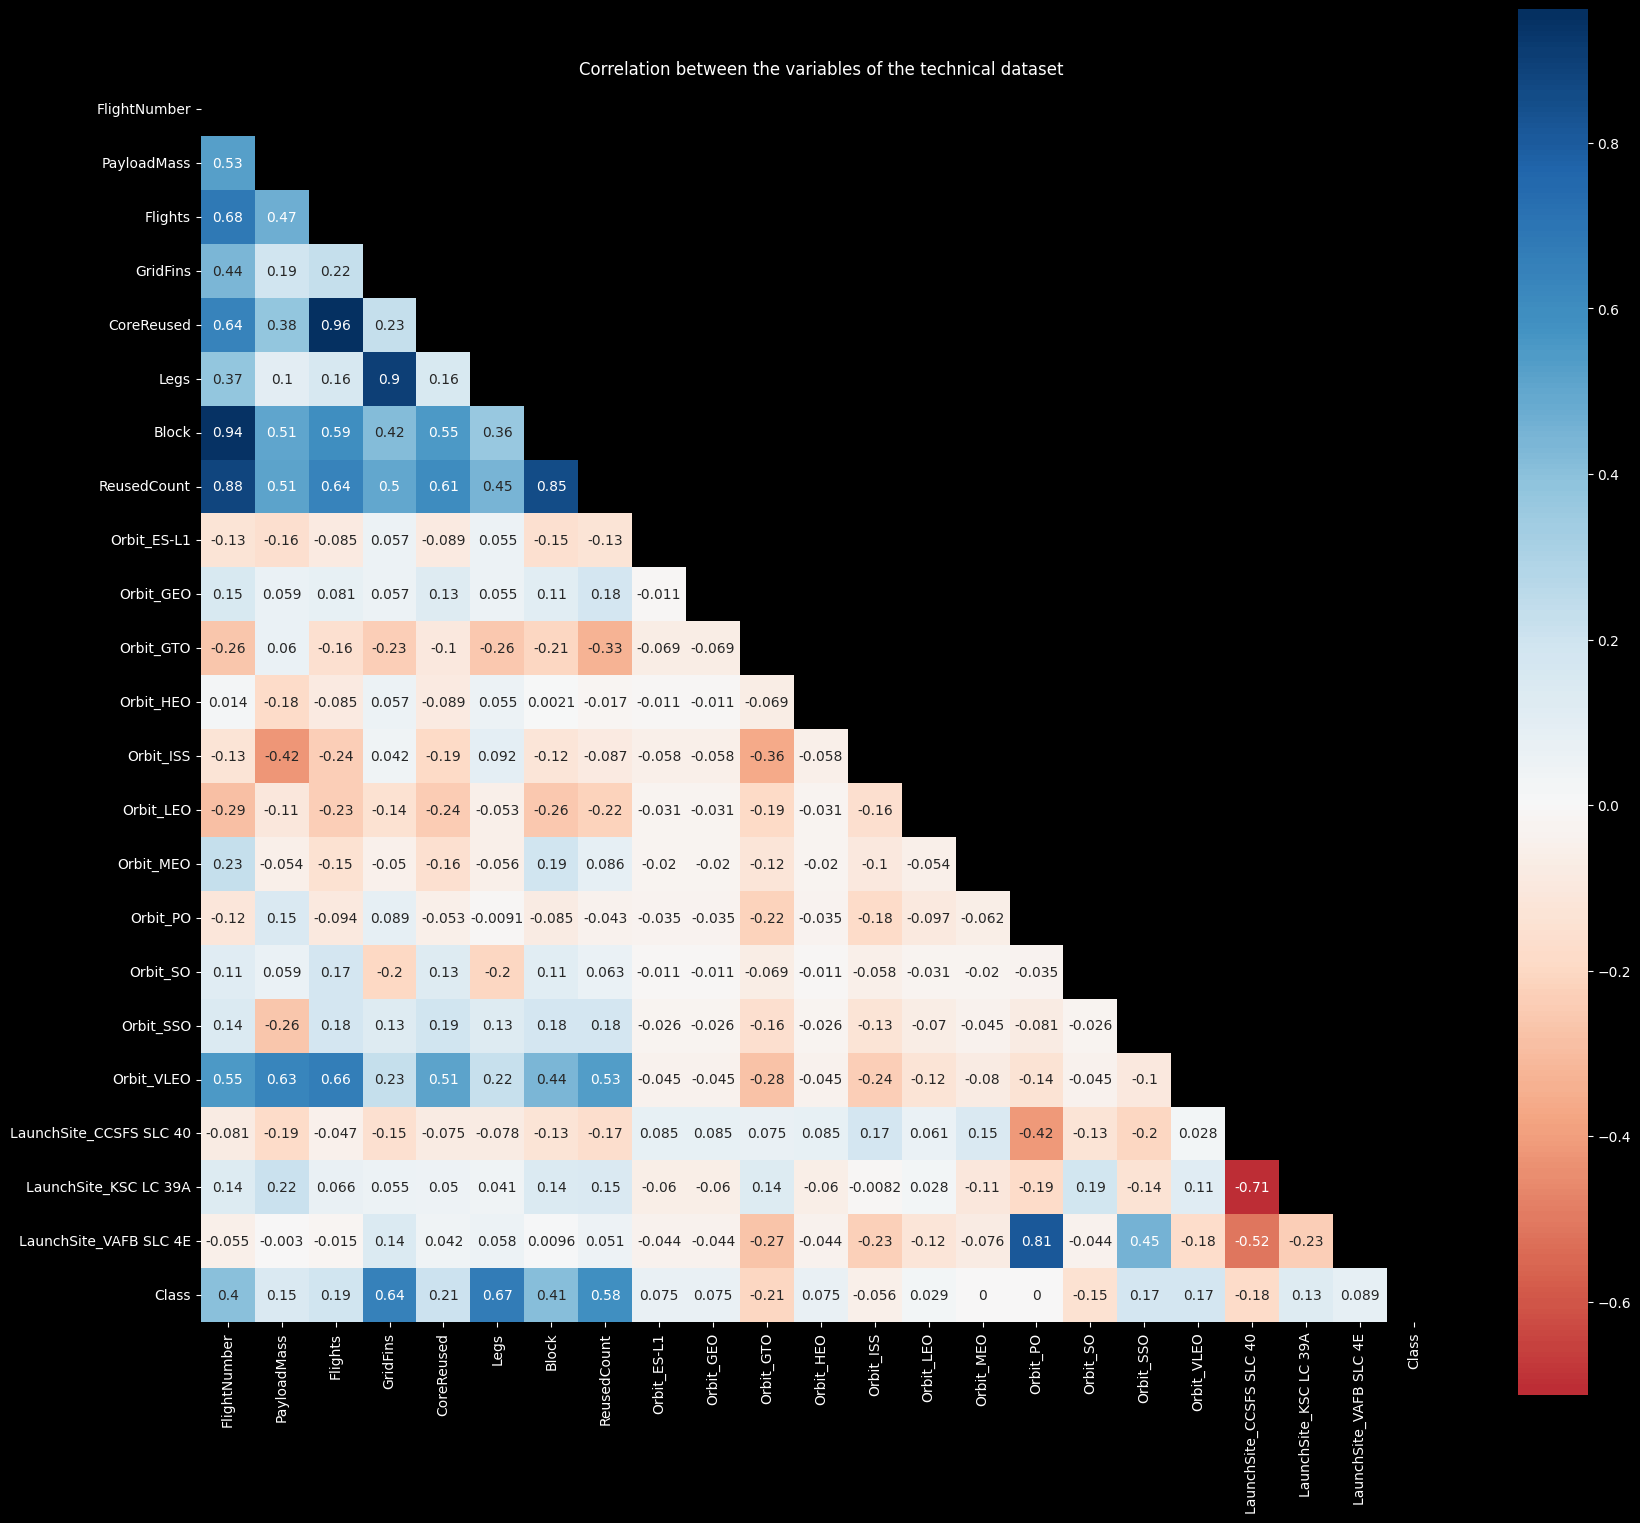

In [77]:
# Take desired features
features = falcon9_technical[['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'CoreReused', 'Legs', 'Block', 'ReusedCount', 'Orbit', 'LaunchSite']]
# Convert categorical variables into numerical values
fea = pd.get_dummies(features)
# Add 'Class` variables
fea['Class'] = falcon9_technical['Class']

# Calculate correlation between all of the variables using `spearman` method
corr = fea.corr(method = 'spearman')
corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.style.use("dark_background")
plt.subplots
f, ax = plt.subplots(figsize=(20, 18))


# Visualize with a correlation matrix heatmap
sns.heatmap(
    corr,
    annot = True,
    mask = mask,
    center = 0,
    square = True,
    cmap = "RdBu",
    xticklabels = 'auto',
)

plt.title('Correlation between the variables of the technical dataset',)

- *It's noticable that `GridFins` and `Legs` have the strongest positive correlation at 0.64 and 0.67, respectively*
- The orbits seem to have the weakest relationships with `Class`
- These insights are helpful later when we build the classification models as variables with the highest correlation with `Class` (target variable) will be chosen.

**In this case, we'll keep all variables as features, only drop features that have extremely low correlation strength with `Class`.**

In [78]:
# Get dummy variables for categorical predictors
features_normalized = pd.get_dummies(features)

# Drop variables with correlation strength lower than 0.1 based on the plot
X = features_normalized.drop(['Orbit_ES-L1', 'Orbit_GEO', 'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO', 'Orbit_SO', 'Orbit_PO', 'LaunchSite_VAFB SLC 4E'], axis = 1)

# Make sure that the value of each variable is in float, not binary (in dummies)
X = X.astype(np.float64)
X.head()

,FlightNumber,PayloadMass,Flights,GridFins,CoreReused,Legs,Block,ReusedCount,Orbit_GTO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### <span style="color:#ff9933">III. Train/test split + Standardize features</span>

Use `train_test_split` with:
- Train:test = 8:2
- Random state = 1 so we can get the same result when reload the notebook
- stratify = y

In Part 2/A/III. when conducting the exploratory analysis, we found that in `Class`, 66.6% are the successful outcome, results in a fact that 33.3(4)% are unsuccessful outcome. This means that we have the successful outcomes doubled the unsuccessful outcomes or the ratio between the outcomes is 2:1.

This is a sign of imbalance and we will split the data using stratify = Y (as Y is `Class`) to make sure that when splitting the data for modeling training, we will receive the data with `Class` with the same 2:1 ratio between successful and unsuccessful as the original data. The method will ensure that there is no bias caused by having more or less data in a certain outcome than it originally is.

In [79]:
# Call 'Class' as our target variable
Y = falcon9_technical['Class'].to_numpy()

# Split data X and Y into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size = 0.2,
    stratify = Y,
    random_state = 282
)
print(
    f"Shape of train/test data\n",
    "Train:", X_train.shape, '\n',
    "Test:", X_test.shape
)

Shape of train/test data
 Train: (72, 13) 
 Test: (18, 13)


**Let's standardize the features of training and test data so they can be used for prediction**

In [80]:
# Fit transform features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **B. Train all the model with default parameters**

### Logistic Regression

By adding `class_weigh = 'balanced`, we ask the model to balance the imbalanced weight between the two class `1` and `0`. As label `1` has twice the number of classes compared to `0`, this adds penalty to `1`, means that we tell the model to less trust this label.

Training Set Accuracy = 0.86111
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.75000   0.87500   0.80769        24
           1    0.93182   0.85417   0.89130        48

    accuracy                        0.86111        72
   macro avg    0.84091   0.86458   0.84950        72
weighted avg    0.87121   0.86111   0.86343        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.66667   0.80000         6
           1    0.85714   1.00000   0.92308        12

    accuracy                        0.88889        18
   macro avg    0.92857   0.83333   0.86154        18
weighted avg    0.90476   0.88889   0.88205        18



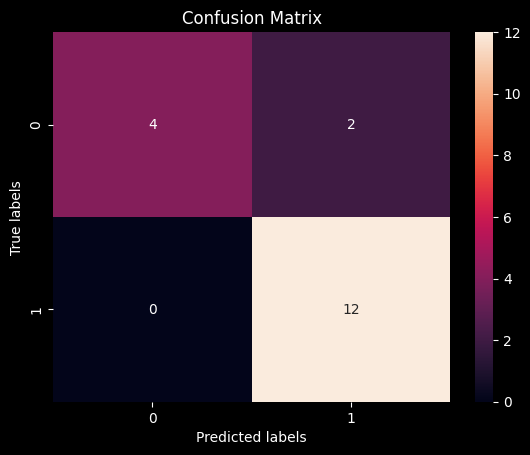

In [ ]:
# Create a model object, then train and predict using `modeling` function
log_model = LogisticRegression(
    class_weight = 'balanced',
    random_state = 282
    )

log_model, log_acc, log_pred_prob = utils.modeling(log_model, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score on the training set is enough for us to say that the model is not overfiting.*
- *The accuracy score is 0.88, this is a high score, shows that the model is reliable*
- *In precision, out of all the flights that the model predicts to be failed, all were actually failed, but for successful flights, 85.7% of the predicted flights to be successful were actually success.*
- *In recall, the model correctly predicts 66.6% of the actually failed flights while also correctly predicts all of the actually successful flights*
- *f1-score for both classes are high, this show that the model is reliable to predict both outcomes. However we can still see that it performs better on predicting successful outcomes (0.923 to 0.800)*

</span>

### Support Vector Machine

Use `poly` as the kernal for SVC(), apply `probability = True` as we need to find the predicted probability of the model for AUC score.

Training Set Accuracy = 0.87500
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.62500   0.76923        24
           1    0.84211   1.00000   0.91429        48

    accuracy                        0.87500        72
   macro avg    0.92105   0.81250   0.84176        72
weighted avg    0.89474   0.87500   0.86593        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.66667   0.80000         6
           1    0.85714   1.00000   0.92308        12

    accuracy                        0.88889        18
   macro avg    0.92857   0.83333   0.86154        18
weighted avg    0.90476   0.88889   0.88205        18



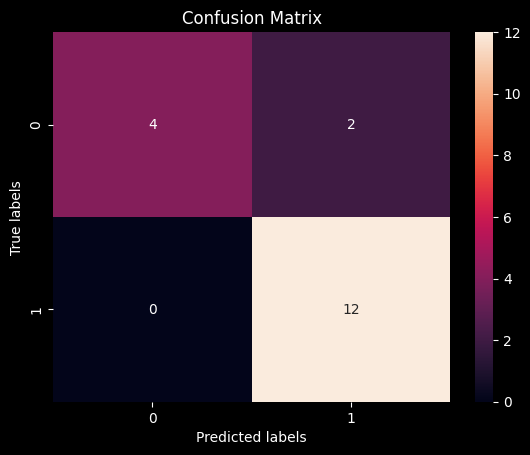

In [ ]:
# Create a model object, then train and predict using `modeling` function
svm_model = SVC(
    kernel = 'poly',
    class_weight = 'balanced',
    probability=True,
    random_state = 282
)

svm_model, svm_acc, svm_pred_prob = utils.modeling(svm_model, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *SVM results are similar to Logistic Regression*
- *The accuracy score is 0.88, this is a high score, shows that the model is reliable*
- *In precision, out of all the flights that the model predicts to be failed, all were actually failed, but for successful flights, 85.7% of the predicted flights to be successful were actually success.*
- *In recall, the model correctly predicts 66.6% of the actually failed flights while also correctly predicts all of the actually successful flights*
- *f1-score for both classes are high, this show that the model is reliable to predict both outcomes. However we can still see that it performs better on predicting successful outcomes (0.923 to 0.800)*

</span>

### Decision Tree

Training Set Accuracy = 1.00000
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        24
           1    1.00000   1.00000   1.00000        48

    accuracy                        1.00000        72
   macro avg    1.00000   1.00000   1.00000        72
weighted avg    1.00000   1.00000   1.00000        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.83333   0.83333   0.83333         6
           1    0.91667   0.91667   0.91667        12

    accuracy                        0.88889        18
   macro avg    0.87500   0.87500   0.87500        18
weighted avg    0.88889   0.88889   0.88889        18



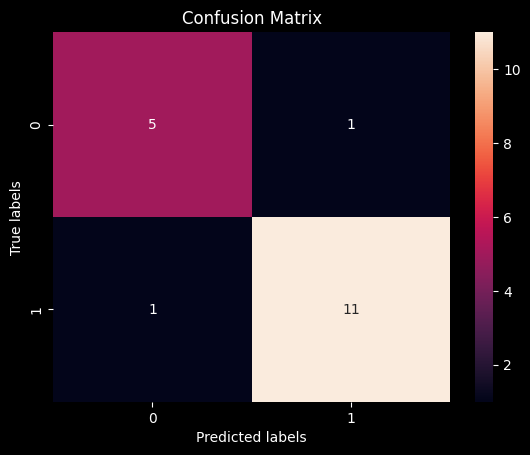

In [ ]:
# Create a model object, then train and predict using `modeling` function
tree_model = DecisionTreeClassifier(random_state=282, class_weight= 'balanced')

tree_model, tree_acc, tree_pred_prob = utils.modeling(tree_model, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score on the training set is 1.00, which is a clear sign of overfitting.*
- *Despite of the high score on the test set, we'll need to further tune the model to see if we can get rid of overfitting as overfitting means that the model learns too much from the training set (even the outliers, unnecessary details). This means that the model is not reliable and may not be able to successful generalize the data.*

</span>

### kNN

Training Set Accuracy = 0.87500
Test Set Accuracy = 0.83333 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.89474   0.70833   0.79070        24
           1    0.86792   0.95833   0.91089        48

    accuracy                        0.87500        72
   macro avg    0.88133   0.83333   0.85079        72
weighted avg    0.87686   0.87500   0.87083        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.80000   0.66667   0.72727         6
           1    0.84615   0.91667   0.88000        12

    accuracy                        0.83333        18
   macro avg    0.82308   0.79167   0.80364        18
weighted avg    0.83077   0.83333   0.82909        18



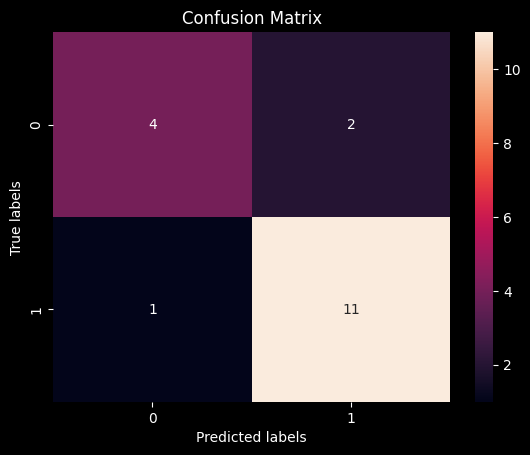

In [ ]:
# Create a model object, then train and predict using `modeling` function
knn_model = KNeighborsClassifier()

knn_model, knn_acc, knn_pred_prob = utils.modeling(knn_model, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score is 0.833, this is a good score, shows that the model generally works well*
- *In precision, out of 80.0% the flights that the model predicts to be failed, 84.6% were actually failed, but for successful flights, all of the predicted flights to be successful were actually success.*
- *In recall, the model correctly predicts 66.6% of the actually failed flights while also correctly predicts 91.6% of the actually successful flights*
- *f1-score for is 15.3% higher at Class 1 at 0.88. This generally shows that the model is very reliable when predicting the success outcomes while perfomrs not as good at Class 0.*

</span>


**All the models seem to work well. However, we will further tune them to see if we can improve the results.**
- Skip Logistic Regression and SVM as they required little tuning to work well and there's also not much to tune in our case.
- Decision Tree is overfitting, we'll aim to get rid of this problem in this model tuning.
- kNN and MLP can be further tuned even though they have high accuracy score (which can be due to randomness):
    - Choose the best number of neighbors for the kNN model is extremely important.
    - The MLP functions requires heavy tuning to actually work well in general.

### XGBoost

Training Set Accuracy = 1.00000
Test Set Accuracy = 0.83333 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        24
           1    1.00000   1.00000   1.00000        48

    accuracy                        1.00000        72
   macro avg    1.00000   1.00000   1.00000        72
weighted avg    1.00000   1.00000   1.00000        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.80000   0.66667   0.72727         6
           1    0.84615   0.91667   0.88000        12

    accuracy                        0.83333        18
   macro avg    0.82308   0.79167   0.80364        18
weighted avg    0.83077   0.83333   0.82909        18



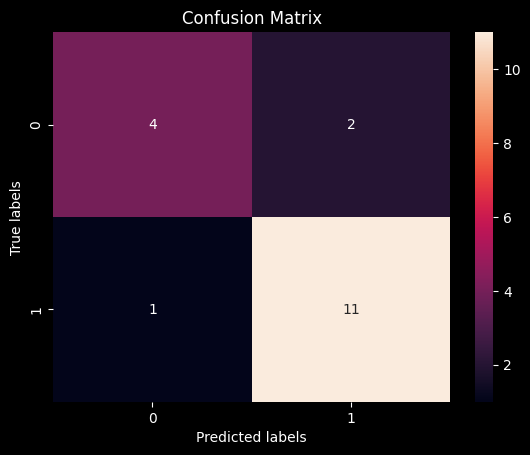

In [ ]:
# Create a model object, then train and predict using `modeling` function
xgb_model = XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=282
)

xgb_model, xgb_acc, xgb_pred_prob = utils.modeling(xgb_model, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score on the training set is 1.00, which is a clear sign of overfitting.*
- *Despite of the good score on the test set, we'll need to further tune the model to see if we can get rid of overfit.*

</span>

## **C1. <span style="color:#ff9933">Tuned</span> Decision Tree**

For the decision tree model, we mainly focus on tuning the depth of the tree by using `max_depth` as this is one of the most important characteristics of the model. Tune this depth in a range from 1 to 10 and make sure that the minimum depth is 2.


In [112]:
# Tune hyperparameters
tree_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2*n for n in range(1,5)],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create a Decision tree GridSearch object
tuned_tree_cv = GridSearchCV(
    tree_model, 
    tree_parameters,
    cv = 10,
    n_jobs = -1,
    scoring = 'accuracy'
)

tuned_tree_cv.fit(X_train, y_train)

# Save the model with the best parameters
tuned_tree_best = tuned_tree_cv.best_estimator_

print("best parameters: ",tuned_tree_cv.best_params_)
print("accuracy :",tuned_tree_cv.best_score_)

best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy : 0.8875


Training Set Accuracy = 0.87500
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.77778   0.87500   0.82353        24
           1    0.93333   0.87500   0.90323        48

    accuracy                        0.87500        72
   macro avg    0.85556   0.87500   0.86338        72
weighted avg    0.88148   0.87500   0.87666        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.83333   0.83333   0.83333         6
           1    0.91667   0.91667   0.91667        12

    accuracy                        0.88889        18
   macro avg    0.87500   0.87500   0.87500        18
weighted avg    0.88889   0.88889   0.88889        18



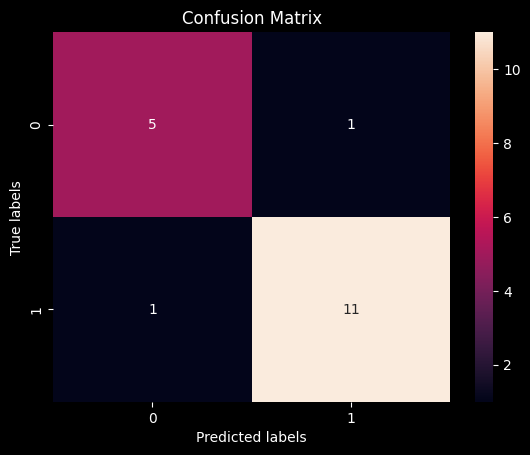

In [ ]:
# Train and predict with the best parameter setting
tuned_tree_model, tuned_tree_acc, tuned_tree_pred_prob = utils.modeling(tuned_tree_cv, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score is 0.889, this is a extremely high score, shows that the model works generally well.*
- *Even though the accuracy score is similar to the untuned version. Note that we can achieve this score without a sign of overfitting observed in the training set.* 
- *In precision, out of all the flights that the model predicted to be successful, 91.6% of them were actually successful, but for failed flights, 83.3% of the predicted flights to be failed were actually failed.*
- *In recall, the model correctly predicted 91.6% of the actually successful flights while correctly predicted 83.3% of the actually failed flights*
- *f1-score shows that the model in general, is more reliable when predicting class `1`.*

</span>

## **C2. <span style="color:#ff9933">Tuned</span> kNN**

**Train a kNN model and ultilize GridSearchCV to find the best parameters**:
- Hyperparameter tuning with GridSearchCV
- Determine how the model performs at different numbers of neighbors

**Parameter notes**:
- `n_neighbors` is the number of neighbors to be used in the model. Here we will try a range with n=1->50.
- `algorithm`: the algorithm used to calculate the nearest neighbors.
- `p`: power parameter for the Minkowski metric, used to find the distance between 2 points.
    - `p=1`: use Manhattan distance as metric
    - `p=2`: use Euclidean distance as metric

In [114]:
# Tune hyperparameters
knn_parameters = {
    'n_neighbors': range(1,51),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
}

# Create a grid search object with kNN
tuned_knn_cv = GridSearchCV(
    knn_model, 
    knn_parameters,
    cv = 10,
    n_jobs = -1
)

tuned_knn_cv.fit(X_train, y_train)

# Save the model with the best parameters
tuned_knn_best = tuned_knn_cv.best_estimator_

print("best parameters: ",tuned_knn_cv.best_params_)
print("accuracy :",tuned_knn_cv.best_score_)

best parameters:  {'algorithm': 'auto', 'n_neighbors': 12, 'p': 1}
accuracy : 0.8482142857142858


**Plot the accuracy score at different k in the range (1-50)**

Text(0, 0.5, 'Average accuracy score')

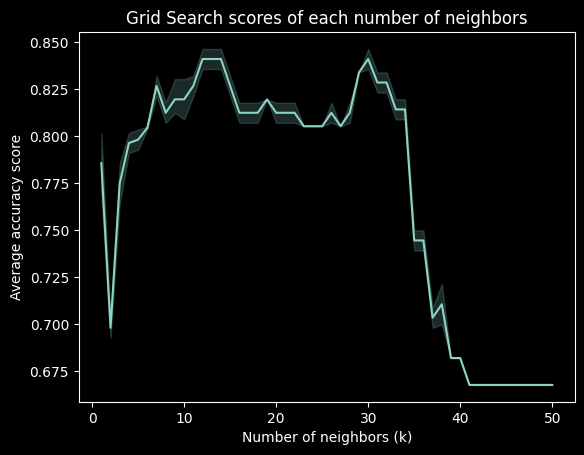

In [115]:
# Convert cv results in array into a dataframe
df = pd.DataFrame(tuned_knn_cv.cv_results_)
# Plot scores using seaborn
ax = plt.subplot()
sns.lineplot(
    df,
    x = 'param_n_neighbors',
    y = 'mean_test_score'
)
ax.set_title('Grid Search scores of each number of neighbors')
ax.set_xlabel('Number of neighbors (k)')
ax.set_ylabel('Average accuracy score')

<span style="color:#ff9933">

- *Highest score observed at n=12. The model's performance decreases significantly after n=34*
- *Note that the faded area shows the error bounds of the accuracy score at different numbers of neighbors. In our case, the errors are observed to be small and their patterns follow the average score line*

</span>

**Retrain the model with the best parameters**

Training Set Accuracy = 0.84722
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.88235   0.62500   0.73171        24
           1    0.83636   0.95833   0.89320        48

    accuracy                        0.84722        72
   macro avg    0.85936   0.79167   0.81246        72
weighted avg    0.85169   0.84722   0.83937        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.66667   0.80000         6
           1    0.85714   1.00000   0.92308        12

    accuracy                        0.88889        18
   macro avg    0.92857   0.83333   0.86154        18
weighted avg    0.90476   0.88889   0.88205        18



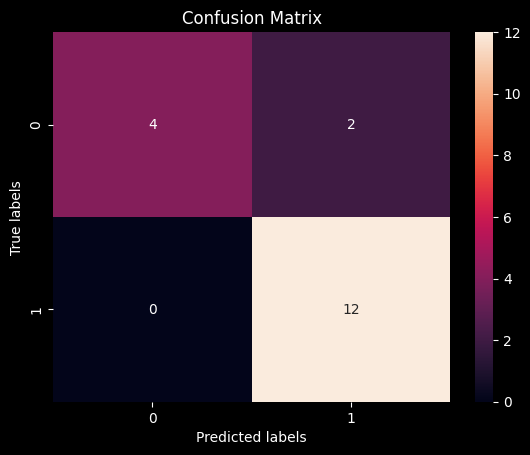

In [ ]:
# Train and predict with the best parameter setting
tuned_knn_model, tuned_knn_acc, tuned_knn_pred_prob = utils.modeling(tuned_knn_best, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score is 0.889, similar to most of our models.*
- *In precision, out of all the flights that the model predicted to be successful, 85.7% of them were really successful. With failed predictions, all of them were actually failed.*
- *In recall, the model correctly predicted all of the actually successful flights while correctly predicted 66.7% of the actually failed flights*
- *f1-score is superior for class `1`.*

</span>

## **C3. <span style="color:#ff9933">Tuned</span> XGBoost**

To tune XGBoost:
- Set up a XGB Classifier model with some important settings. 
    - We ultilize objective as 'binary:logistic' as we our target is a binary variable and we need to use logistic function to solve these type of variable.
    - `use_label_encoder=False` as we don't need it and it will also return an unimportant warning message if we don't turn off.
    - `eval_metric = 'logloss'` as we are using negative log-likelihood as our evaluation metric for the validation data.
- Tune each parameter at a time, then adds the parameter with its best tuning values into `xgb_parameters` once we have the results. The next-to-be-tuned parameter will be tuned together with the previously tuned parameter(s).
- Start from `max_depth`, which is the depth of the tree, as it is not dependent by other hyperparameters.
- Then tune and add the parameters in one by one following this list:
    - `subsample`: the fraction of observastgetions to be randomly samples for each tree.
    - `min_child_weight`: the minimum sum of weights of all observations required in a child.
    - `colsample_bytree`: the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    - `eta`: It is analogous to learning rate in GBM. It is the step size shrinkage used in update to prevent overfitting.
- For `gamma` and `reg_lambda` - both related to our L2 penalization, we will try different values of them to see which fits the best to prevent overfitting.

In [173]:
xgb_model = XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder = False, 
    eval_metric = 'logloss',
    random_state = 282,
)

xgb_parameters = {
    'max_depth': [2*n for n in range(1,5)],
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'eta': [0.3, 0.4],    
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0]
}

# Create a gridsearch object with XGB
tuned_xgb_cv = GridSearchCV(
    xgb_model, 
    xgb_parameters,
    cv = 10,
    n_jobs = -1
)

tuned_xgb_cv.fit(X_train, y_train)

# Assign important variables for future reuse
tuned_xgb_acc = tuned_xgb_cv.best_score_
tuned_xgb_best = tuned_xgb_cv.best_estimator_


print("best parameters: ",tuned_xgb_cv.best_params_)
print("accuracy :",tuned_xgb_acc)

best parameters:  {'colsample_bytree': 0.8, 'eta': 0.4, 'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 1, 'reg_lambda': 0.1, 'subsample': 0.6}
accuracy : 0.8625


Training Set Accuracy = 0.95833
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.95652   0.91667   0.93617        24
           1    0.95918   0.97917   0.96907        48

    accuracy                        0.95833        72
   macro avg    0.95785   0.94792   0.95262        72
weighted avg    0.95830   0.95833   0.95810        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    0.83333   0.83333   0.83333         6
           1    0.91667   0.91667   0.91667        12

    accuracy                        0.88889        18
   macro avg    0.87500   0.87500   0.87500        18
weighted avg    0.88889   0.88889   0.88889        18



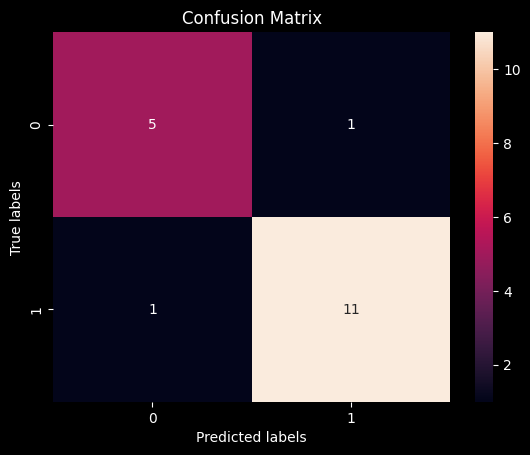

In [174]:
# Retrain the model with the best tuned hyperparameters
tuned_xgb_model, tuned_xgb_acc, tuned_xgb_pred_prob = modeling(tuned_xgb_best, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score is 0.889, which is 0.05 higher than the untuned model (0.83). Note that the accuracy score on the training set shows that we are successful in getting rid of overfitting.*
- *In precision, out of all the flights that the model predicted to be successful, 91.6% of them were actually successful, but for failed flights, 83.3% of the predicted flights to be failed were actually failed.*
- *In recall, the model correctly predicted 91.6% of the actually successful flights while correctly predicted 83.3% of the actually failed flights*
- *f1-score shows that the model in general, is more reliable when predicting class `1`.*
</span>

## **C4. <span style="color:#ff9933">Tuned</span> MLP**

Neural Network is one of the most interesting model that we can use to classify the labels. MLP is usually complex, requires heavy tuning and may not very appropriate (not worth the building cost) for our case - in which we are only using a small dataset.

**Find the best hyperparameters**

- `hidden_layer_sizes`: change the number of element and the number of layer of the neural network.
- `activation`: functions used for the layers/the neurons in the network. We will try some of the non-linear functions in the model.
- `alpha`: regularization strength, similar to LR models's `C`.
- `solver`: Optimization function used for the neural network. Here used to have `lbfgs` and `adam` but I remove them because after many tests and trys `sgd` seems to have the best results. Also removing them will significantly reduce the calculation time, save memory and resources.
   
(with `solver` = `sgd`)
- Learning rate is the weight/speed at which the model learns from the data. Higher means learn more but can be overfitting while lower learns the data slower, with more accuracy but can takes a lot of time.
- `learning_rate_init`: The initial learning rate used, manipulates the step-size in updating the weights
- `learning_rate`: how the model learns from the data, two methods are two different ways the model change the learning_rate_init.

In [ ]:
# Tune hyperparameters
mlp_parameters = {
    'hidden_layer_sizes': [(10,), (10,5), (15,), (30,), (40,), (40,10)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.6, 1, 5],
    'solver': ['sgd', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400]
}

mlp_model = MLPClassifier(
    random_state = 282,
    early_stopping = True # Stop training if validation score does not improve
)

# Create a GridSearch object with MLP
tuned_mlp_cv = GridSearchCV(
    mlp_model, 
    mlp_parameters,
    cv = 5, # Reduce the number of cv to decrease training time
    n_jobs = -1 # Ultilize all CPU processors to decrease training time
)

tuned_mlp_cv.fit(X_train, y_train)

# Assign important variables for future reuse
tuned_mlp_acc = tuned_mlp_cv.best_score_
tuned_mlp_best = tuned_mlp_cv.best_estimator_


print("best parameters: ",tuned_mlp_cv.best_params_)
print("accuracy :",tuned_mlp_acc)

Training Set Accuracy = 0.93056
Test Set Accuracy = 0.88889 

Training Set Classification Report:
              precision    recall  f1-score   support

           0    0.95238   0.83333   0.88889        24
           1    0.92157   0.97917   0.94949        48

    accuracy                        0.93056        72
   macro avg    0.93697   0.90625   0.91919        72
weighted avg    0.93184   0.93056   0.92929        72

Test Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.66667   0.80000         6
           1    0.85714   1.00000   0.92308        12

    accuracy                        0.88889        18
   macro avg    0.92857   0.83333   0.86154        18
weighted avg    0.90476   0.88889   0.88205        18



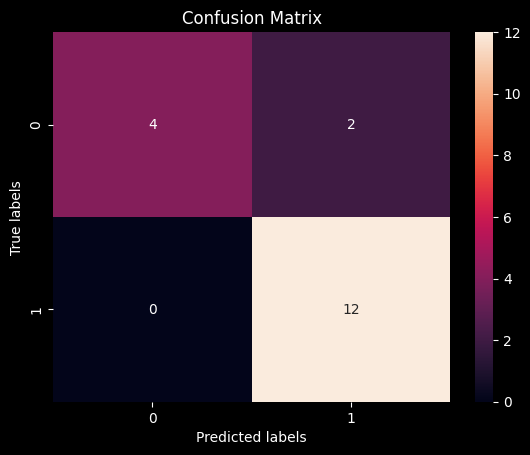

In [172]:
# Retrain the model with the best tuned hyperparameters
tuned_mlp_model, tuned_mlp_acc, tuned_mlp_pred_prob = modeling(tuned_mlp_best, X_train, y_train, X_test, y_test)

<span style="color:#ff9933">

- *The accuracy score is 0.889, the model seems to be reliable.*
- *In precision, out of all the flights that the model predicted to be successful, 85.7% of them were really successful. With failed predictions, all of them were actually failed.*
- *In recall, the model correctly predicted all of the actually successful flights while correctly predicted 66.7% of the actually failed flights*
- *f1-score is superior for class `1`.*

</span>

## **D. Conclusion**

Neglect the result of the default Decision Tree model as it is overfitting.

### Accuracy Score

In [195]:
# Create a list of each model's accuracy score
accuracy_data = {
        'Model': ['Logistic Regression', 'SVM',  'KNN','XGBoost', 'Tuned Decision Tree', 'Tuned kNN', 'Tuned XGBoost', 'Tuned MLP'],
        'Accuracy': [log_acc, svm_acc, knn_acc, xgb_acc, tuned_tree_acc, tuned_knn_acc, tuned_xgb_acc, tuned_mlp_acc]
}
  
# Create DataFrame
accuracy_report = pd.DataFrame(accuracy_data)
accuracy_report['Accuracy'] = accuracy_report['Accuracy'].astype('float').round(3)
  
# Print the output.
accuracy_report

,Model,Accuracy
0,Logistic Regression,0.889
1,SVM,0.889
2,KNN,0.833
3,XGBoost,0.833
4,Tuned Decision Tree,0.889
5,Tuned kNN,0.889
6,Tuned XGBoost,0.889
7,Tuned MLP,0.889


In [196]:
ax = px.bar(
    accuracy_report,
    x = 'Model',
    y = 'Accuracy',
    color = 'Model',
    width = 800,
    height = 600,
    color_discrete_sequence = ['#fd7e14', '#ffdf64','#06D6A0','#43b2e5', '#0E273C', '#5f5566', '#F9EAE1']
)

ax.update_layout(
    font = dict(color = 'white'),
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    paper_bgcolor = 'rgba(0, 0, 0, 0)'
)
ax.update_xaxes(
    showgrid = False,
    zeroline = False
)
ax.update_yaxes(
    showgrid = False,
    zeroline = False
)
ax.update_traces(
    hovertemplate = None
)

ax

<span style="color:#ff9933">

- *Most of the models have similar accuracy score of 0.88, default kNN and XGBoost has the lowest accuracy of 0.83*
- *The high score results are due to all of these criteria happen simultaneously:*
    - *Before fitting the models, we have done some preprocessing steps which generally improve the model performance: features engineering, remove low correlated features (which also reduces multicollinearity between some variables), stratification, ..*
    - *The data (especially the test set) is relatively small. Which means that there is a high chance for the models to have similarly high scores and differences between models may not be visible observed*

</span>

- **Important effects of hyperparamter tuning can be seen**: Tuning the models may not significantly changes the accuracy score in this case, but it helps the model to better classify two classes of the target variable. It makes the model's score becomes more reliable and trustworthy.
    - *In Decision Tree, hyperparameters tuning helps reducing overfitting, which originally made the model bias and follow the data pattern of the train set strictly,*
    - *In kNN, not only could we achieve a higher prediction score on the test set, but we can also get a lower score on the train set. This means that tuning the model improves its prediction performance as well as its ability to generalize the dataset and not heavliy depend on/bias training data.*
    - *In XGBoost, tuned hyperparameters help the model to yield a better result and reduce overfitting.*

- *To further refine & determine the performance of the models, we need bigger training/test data*

### ROC curve (receiver operating characteristic curve)

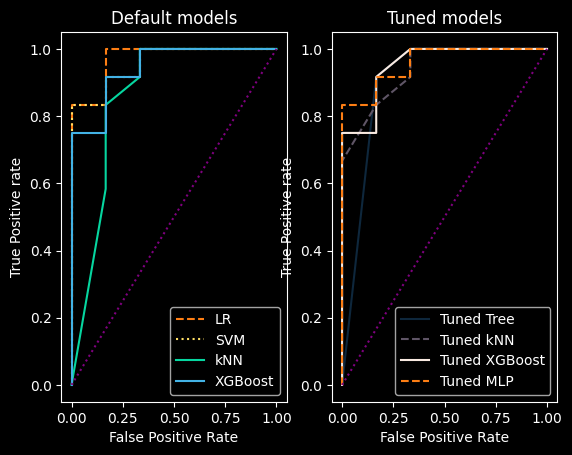

In [200]:
# Take FPR, TPR and thresh using 'roc_curve()'
fpr_log, tpr_log, thresh_log = roc_curve(y_test, log_pred_prob[:,1], pos_label=1)
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, svm_pred_prob[:,1], pos_label=1)
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, knn_pred_prob[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, xgb_pred_prob[:,1], pos_label=1)
fpr_tuned_tree, tpr_tuned_tree, thresh_tuned_tree = roc_curve(y_test, tuned_tree_pred_prob[:,1], pos_label=1)
fpr_tuned_knn, tpr_tuned_knn, thresh_tuned_knn = roc_curve(y_test, tuned_knn_pred_prob[:,1], pos_label=1)
fpr_tuned_xgb, tpr_tuned_xgb, thresh_tuned_xgb = roc_curve(y_test, tuned_xgb_pred_prob[:,1], pos_label=1)
fpr_tuned_mlp, tpr_tuned_mlp, thresh_tuned_mlp = roc_curve(y_test, tuned_mlp_pred_prob[:,1], pos_label=1)

# FPR = TPR
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Plot roc curves
plt.subplot(1,2,1)
plt.plot(fpr_log, tpr_log, linestyle='--',color='#fd7e14', label='LR')
plt.plot(fpr_svm, tpr_svm, linestyle=':',color='#ffdf64', label='SVM')
plt.plot(fpr_knn, tpr_knn, linestyle='-',color='#06D6A0', label='kNN')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-',color='#43b2e5', label='XGBoost')
plt.plot(p_fpr, p_tpr, linestyle=':', color='purple')

plt.title('Default models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.grid(False)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(fpr_tuned_tree, tpr_tuned_tree, linestyle='-',color='#0E273C', label='Tuned Tree')
plt.plot(fpr_tuned_knn, tpr_tuned_knn, linestyle='--',color='#5f5566', label='Tuned kNN')
plt.plot(fpr_tuned_xgb, tpr_tuned_xgb, linestyle='-',color='#F9EAE1', label='Tuned XGBoost')
plt.plot(fpr_tuned_mlp, tpr_tuned_mlp, linestyle='--',color='#fd7e14', label='Tuned MLP')
plt.plot(p_fpr, p_tpr, linestyle=':', color='purple')

plt.title('Tuned models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.grid(False)
plt.show();

<span style="color:#ff9933">

- *There is no model outperforms others other has a significantly lower rate.*
- *In untuned models, it's visible that LR and SVM work slightly better compared to other models.*
- *In tuned models, Tuned MLP and XGBoost work better than other models.*
- *We'll need to print out the AUC score so compare the actual differences between each model.* 
   
</span>

In [202]:
# Print the auc score of the models
auc_score_log = roc_auc_score(y_test, log_pred_prob[:,1]).round(3)
auc_score_svm = roc_auc_score(y_test, svm_pred_prob[:,1]).round(3)
auc_score_knn = roc_auc_score(y_test, knn_pred_prob[:,1]).round(3)
auc_score_xgb = roc_auc_score(y_test, xgb_pred_prob[:,1]).round(3)
auc_score_tuned_tree = roc_auc_score(y_test, tuned_tree_pred_prob[:,1]).round(3)
auc_score_tuned_knn = roc_auc_score(y_test, tuned_knn_pred_prob[:,1]).round(3)
auc_score_tuned_xgb = roc_auc_score(y_test, tuned_xgb_pred_prob[:,1]).round(3)
auc_score_tuned_mlp = roc_auc_score(y_test, tuned_mlp_pred_prob[:,1]).round(3)

print(
    'AUC score of LR:', auc_score_log,'\n'
    'AUC score of SVM:', auc_score_svm,'\n'
    'AUC score of kNN:', auc_score_knn,'\n'
    'AUC score of XGBoost:', auc_score_xgb,'\n'
    'AUC score of tuned Decision Tree:', auc_score_tuned_tree,'\n'
    'AUC score of tuned kNN:', auc_score_tuned_knn,'\n'
    'AUC score of tuned XGBoost:', auc_score_tuned_xgb,'\n'
    'AUC score of tuned MLP:', auc_score_tuned_mlp
)

AUC score of LR: 0.972 
AUC score of SVM: 0.958 
AUC score of kNN: 0.861 
AUC score of XGBoost: 0.944 
AUC score of tuned Decision Tree: 0.903 
AUC score of tuned kNN: 0.937 
AUC score of tuned XGBoost: 0.951 
AUC score of tuned MLP: 0.958


<span style="color:#ff9933">

- *All of the models have excellent AUC scores.*
- *Logistic Regression has the best score of 0.97 means that 97% of its predictions are correct.*
- *Second place at score of 0.958: SVM, Tuned MLP*
- *kNN has the lowest AUC score of 0.86 means that 0.86% of its predictions are correct. This is still a great score.*
- *It is normal to achieve these score as we have preprocessed our data before modeling and also because we have a small dataset which make prediction easier.*
   
</span>